## Lindgren, Eric
## 970222-1954

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set("talk") # for plot formatting
import emcee

import scipy
import scipy.optimize as opt
import corner
from tqdm import tqdm_notebook

# Problem 5

## Task a)

Text(0.5, 1.0, 'Generated data')

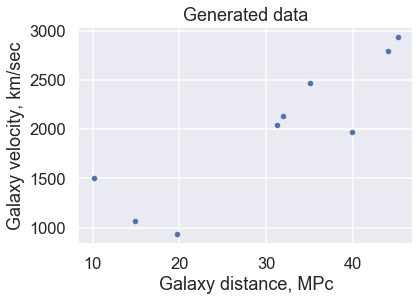

In [2]:
# Data from student lab observations; 
# x = Galaxy distances in MPc
# y = Galaxy velocity in km/sec
x = np.array([10.1 ,45.2, 19.7, 31.2, 31.9, 44.0,
       14.9, 35.1,  39.9  ])
y = np.array([1507.9, 2937.5,  930.4, 2037.1, 2131.1,
       2795.6, 1061.8, 2464.8, 
       1971.1])
sigma = 200

# Plot data
fig, ax = plt.subplots()
ax.plot(x,y, 'b.', label='Data')
ax.set_xlabel("Galaxy distance, MPc")
ax.set_ylabel("Galaxy velocity, km/sec")
plt.title("Generated data")

No error on x, and a constant standard deviation of $\sigma$ on y. This makes the probability to measure a certain datapoint to be normally distributed around the model value: 

$$p(x_i,y_i|M, I) \sim N(y_M(x_i;\theta), \sigma) $$

where $\theta$ are the model parameters. The total likelihood is thus:

$$ \log{p(D|M,I)} = \log{\prod_{i=0}^{N-1}p(x_i, y_i|M,I)} = -N \log{\sqrt{2\pi\sigma^2}} + \sum_{i=0}^{N-1} \frac{-[y_i-y_M(x_i;\theta)]}{2\sigma^2}  $$

We make the prior that the data can be fitted with a straight line. Thus our model $M$ only has two parameters in $\theta$: the intercept $m$ and the slope $k$. Hubbles law states that $y = H_0 \cdot x$, which means that we are only really interested in $k$.

#### Step 1: Maximum likelihood estimate

In [3]:
# return a simple maximum likelihood estimate
def log_likelihood(theta, x, y, sigma):
    term_1 = -len(x)*np.log(2*np.pi*sigma**2)
    y_M = theta[0]*np.ones((len(x))) + theta[1]*x
    term_2 = (-(y-y_M)**2/(2*sigma**2)).sum()
    return term_1 + term_2


def negative_log_likelihood(theta,x,y,sigma):
    return -log_likelihood(theta, x, y, sigma)

# Maximize using scipy optimize
max_like_est = opt.minimize(negative_log_likelihood, [0,0], args=(x, y, sigma))
display(f'Maximum likelihood approach yields: m, k={max_like_est.x}')

'Maximum likelihood approach yields: m, k=[506.32926036  48.824909  ]'

The maximum likelihood estimate for the Hubble constant is $H_0 \approx 48.8$.

#### Step 2: Bayesian analysis

In [4]:
def log_prior_intercept(m, sigma):
    fun = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(np.abs(m)**2)/(2*sigma**2))
    return np.log(fun)


def log_prior_slope(k):
    fun =  1/(1+k**2)**(3/2)
    return np.log(fun)


def log_posterior(theta, x, y, sigma):
    log_like = log_likelihood(theta, x, y, sigma)
    # Assume m and k to be independent. Then their joint pdf is the product
    # of the two.
    log_prior = log_prior_intercept(theta[0],sigma) + log_prior_slope(theta[1])
    return log_like + log_prior


def negative_log_posterior(theta, x, y, sigma):
    return -log_posterior(theta,x,y,sigma)


def calc_dob_interval(marg_k, ks, mode_idx, dob=0.68):
    '''
    Calculate a dob interval for the marginal pdf for k. Start at the mode, and go out until as close to dob% as 
    possible has been collected. Returns the endpoints of the interval. 
    '''
    interval = 0
    start_idx = mode_idx
    end_idx = mode_idx
    # Save latest interval as well, to compare at the end
    last_interval = 0
    while interval < dob:
        # Save the previous interval
        last_interval = interval
        # Take a step in either direction
        start_idx -= 1
        end_idx += 1
        interval = np.trapz(marg_k[start_idx:end_idx], ks[start_idx:end_idx])
    # Check which is closer to dob%. Return k-values corresponding to that interval.
    if np.abs(interval-dob) < np.abs(last_interval-dob):
        return ks[start_idx], ks[end_idx]
    else: 
        return ks[start_idx+1], ks[end_idx-1]

In [23]:
# Evaluate this posterior on a grid and find a 68% DOB interval
ks = np.linspace(30,70,200)
ms = np.linspace(-100,700,200)

sigma = 200
evaluated_posterior = np.zeros((len(ks), len(ms)))  # contour wants first index to be -> and second to be ^

for i, k in enumerate(ks):
    for j, m in enumerate(ms):
        evaluated_posterior[i,j] = log_posterior([m,k], x, y, sigma)
        
# Extract the marginal densities and a DOB interval for k
marg_k = np.zeros(len(ks))
marg_m = np.zeros(len(ms))
for i in range(len(ks)):
    marg_k[i] = np.sum(np.exp(evaluated_posterior)[i,:])
for j in range(len(ms)):
    marg_m[j] = np.sum(np.exp(evaluated_posterior)[:,j])
    
# Normalize marginal pdfs:
marg_k=marg_k/np.trapz(marg_k, ks)
marg_m=marg_m/np.trapz(marg_m, ms)

# Calculate and plot DoB nterval
mode_idx = marg_k.argmax()
k_mode = ks[mode_idx]
dob = 0.68
dob_interval = calc_dob_interval(marg_k, ks, mode_idx, dob)

print(f'The full Bayesian analysis for k yields a {dob*100}% degree of belief interval as {np.round(dob_interval[0],2)} km/(MPc sec) < k < {np.round(dob_interval[1],2)} km/(MPc sec), with the mode being at k={np.round(k_mode,2)} km/(MPc sec)')

The full Bayesian analysis for k yields a 68.0% degree of belief interval as 49.9 km/(MPc sec) < k < 58.74 km/(MPc sec), with the mode being at k=54.32 km/(MPc sec)


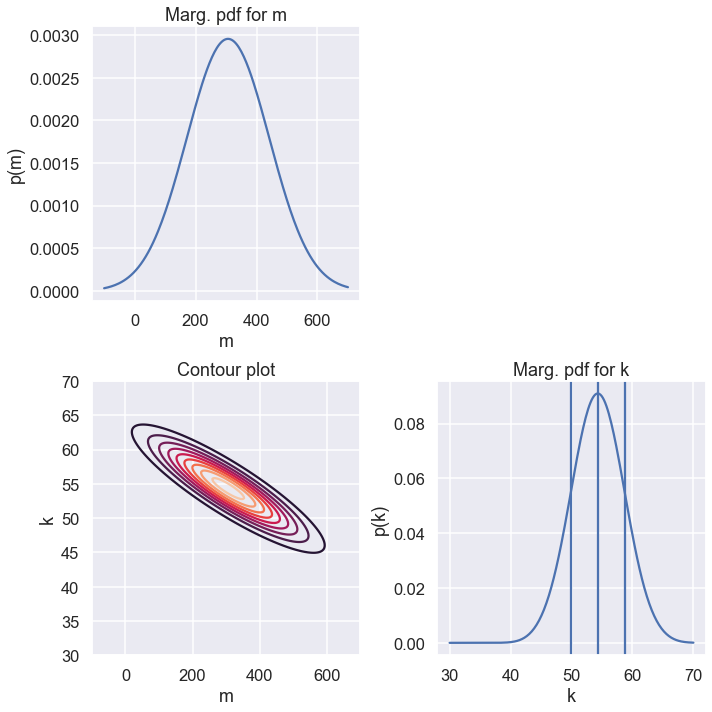

In [25]:
# Plot
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,1].set_visible(False)
ax[1,0].set_title("Contour plot")
ax[1,0].set_xlabel("m")
ax[1,0].set_ylabel("k")
ax[1,0].contour(ms,ks, np.exp(evaluated_posterior), 10)

ax[1,1].set_title("Marg. pdf for k")
ax[1,1].plot(ks,marg_k)
ax[1,1].set_ylabel("p(k)")
ax[1,1].set_xlabel("k")
ax[1,1].axvline(k_mode)
ax[1,1].axvline(dob_interval[0])
ax[1,1].axvline(dob_interval[1])


ax[0,0].set_title("Marg. pdf for m")
ax[0,0].plot(ms,marg_m)
ax[0,0].set_ylabel("p(m)")
ax[0,0].set_xlabel("m")
plt.tight_layout()
plt.rcParams["figure.figsize"]=10,10

#### Step 3: Bayesian approach to Outliers (good-data/bad-data)

In [18]:
def complicated_likelihood(m, k, g, x, y, sigma):
    # Check g again in here - since evaluating all priors together
    if (g > 0).all() and (np.abs(g) <= 1).all():
        data_terms = np.zeros((len(x)))
        # The likelihood is the product over all i
        for i in range(len(x)):
            y_M = m + k*x[i]
            gauss = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-((y_M-y[i])**2)/(2*sigma**2))
            lorentz = 1/(np.sqrt(2)*np.pi*sigma)*1/(1+((y_M-y[i])**2)/(2*sigma**2))
            # The likelihood is the product over all i
            data_terms[i] = g[i]*(gauss) + (1-g[i])*lorentz
        return np.prod(data_terms)
    else:
        # This corresponds to g being outside the valid interval
        return 0


def log_prior_g(g):
    if (g > 0).all() and (np.abs(g) <= 1).all():
        return 0  # log(1)
    else: 
        return -np.inf  # log(0)


def log_complicated_posterior(input_vec, x, y, sigma):
    m = input_vec[0]
    k = input_vec[1]
    g = input_vec[2:2+len(x)]
    log_prior = log_prior_intercept(m,sigma) + log_prior_slope(k) + log_prior_g(g)
    log_likelihood = np.log(complicated_likelihood(m, k, g, x, y, sigma))
    log_posterior = log_prior + log_likelihood
    return log_posterior

In [19]:
# Use an emcee sampler to explore the parameter space for this pdf. 
# Study the log of this pdf

ndim = 2+len(x) # m, k, {gi}
nwalkers = 4*ndim  # nbr of mcmc walkers
# Create the starting position in eps, g, k, m, space
p0 = np.zeros(ndim * nwalkers).reshape((nwalkers, ndim))  # Randomize start
# Initialize our first guess
for walker in range(nwalkers):
    p0[walker, 0] = 400+100*np.random.rand() # We know from our previous measurements the region for m
    p0[walker, 1] = 50+10*np.random.rand()  # We know from our previous measurements the region for k
    p0[walker, 2:] = np.random.rand(ndim - 2)  # Randomize the last g parameters

nburnin = 500
nsteps = 5000
    
# Define the sampler
arglist = (x, y, sigma)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_complicated_posterior, args=arglist)
# Burn-in
pos, prob, state = sampler.run_mcmc(p0, nburnin)
sampler.reset()
# Start the walk
sampler.run_mcmc(pos, nsteps)
print("Done sampling")

C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Done sampling


Mean of H0=59.33


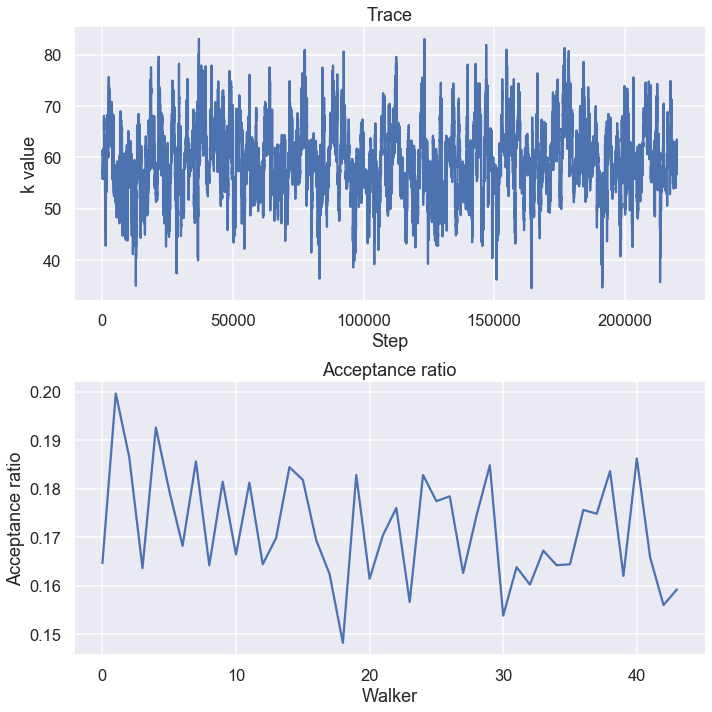

In [27]:
# Marginalize out m, g and plot k - do this by dropping the required columns
k_samples = np.copy(sampler.chain[:,:,1])
# Also get m samples for corner plot
m_samples = np.copy(sampler.chain[:,:,0])
# Flatten array to get info from all 10 walkers
k_samples = k_samples.flatten()
m_samples = m_samples.flatten()

# Calculate the mean of H0 and use that for the following analysis
H0 = k_samples.mean()
print(f'Mean of H0={np.round(H0,2)}')

# Plot trace and acceptance fraction
figtrace, axtr = plt.subplots(2,figsize=(10,10))
axtr[0].set_title("Trace")
axtr[0].plot(k_samples)
axtr[0].set_xlabel("Step")
axtr[0].set_ylabel("k value")
axtr[1].set_title("Acceptance ratio")
axtr[1].plot(sampler.acceptance_fraction)
axtr[1].set_xlabel("Walker")
axtr[1].set_ylabel("Acceptance ratio")
plt.tight_layout()

Corner plot showing the sampled pdfs for m and k, with a 68.0% DOB interval given. The mean is 59.33


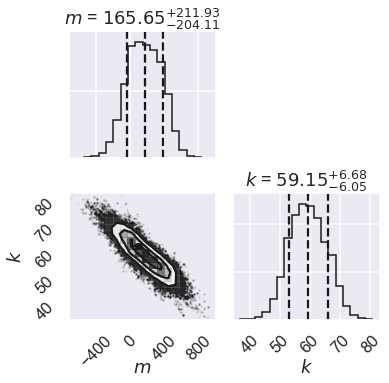

In [32]:
# Draw a corner plot for m and k
m_k_samples = np.zeros((len(k_samples), 2))
m_k_samples[:,0] = m_samples
m_k_samples[:,1] = k_samples
dob = 0.68
dob_half = (1-dob)/2
fig = corner.corner(m_k_samples, labels=[r'$m$', r'$k$'], quantiles=[dob_half, 0.5, 1-dob_half],
                        show_titles=True, hist_kwargs={'density': True})
fig.tight_layout()

H0 = k_samples.mean()
print(f'Corner plot showing the sampled pdfs for m and k, with a {dob*100}% DOB interval given. The mean is {(H0):.2f} km/sec/MPc')

## Task b

The distance to the galaxy for case one is given by the pdf in the figure, with mode 1665.0 MPc.


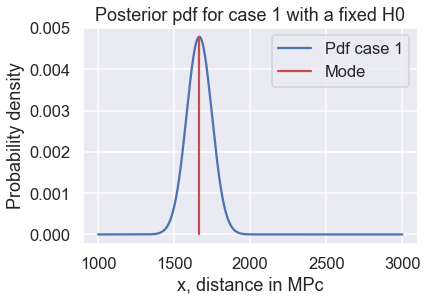

In [10]:
# Case 1 - here we assume H0 to be "perfect", with no error
def posterior_case1(x, vmeasured, sigmav, H0):
    fun = 1/(np.sqrt(2*np.pi)*sigmav)*np.exp(-(vmeasured-H0*x)**2/(2*sigmav**2))
    return fun
    
x_min = 1000  # Mpc
x_max = 3000 # MPc
xt = np.linspace(x_min, x_max, 1000)

vm = 100000  # km/sec
sig_vm = 5000  #

# Plot the posterior pdf
fig, ax = plt.subplots()
posterior_pdf = posterior_case1(xt, vm, sig_vm, H0)
norm_post = posterior_pdf/np.trapz(posterior_pdf,xt)

# calc mode of pdf
mode_idx =np.argmax(norm_post)
mode_pos = xt[mode_idx]
mode_height = np.amax(norm_post)
ax.plot(xt, norm_post, label="Pdf case 1")
ax.plot([mode_pos,mode_pos], [0,mode_height], 'r', label="Mode")
plt.legend()
ax.set_xlabel("x, distance in MPc")
ax.set_ylabel("Probability density")
plt.title("Posterior pdf for case 1 with a fixed H0")

print(f'The distance to the galaxy for case one is given by the pdf in the figure, with mode {round(mode_pos)} MPc.')

The distance to the galaxy for case one is given by the pdf in the figure, with (one of the) mode(s) 1667.0 MPc.


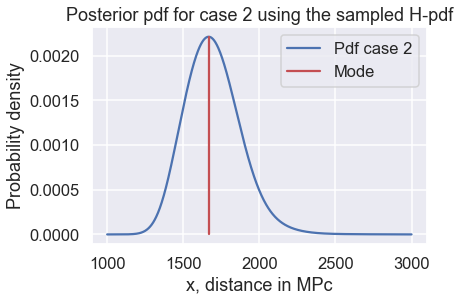

In [11]:
# Case 2
# In our case, p(D|Hi,I) = p(y|x,sigma,Hi,I), the likelihood for measuring our data. 
# We utilize the fact that the datapoints are distributed according to a Gaussian with mean 0 and standard deviation sigmav
# But this is just the posterior for case1, so we use it again.

def posterior_case_vector(xs, vmeasured, sigmav, Hs):
    '''Vectorized version of the function from case1'''
    # reshape H and x to create a matrix
    Hs = Hs.reshape((len(Hs),1))
    xs = xs.reshape((1,len(xs)))
    fun = 1/(np.sqrt(2*np.pi)*sigmav)*np.exp(-(vmeasured-Hs.dot(xs))**2/(2*sigmav**2))
    return fun

def posterior_case2(x, vmeasured, sigmav, H):
    '''
    Calculate the posterior pdf using the MCMC sampled pdf for H0
    '''
    posterior_pdf = posterior_case_vector(x, vmeasured, sigmav, H)
    # Sum over all H, which are index 0
    post_sum = posterior_pdf.sum(axis=0)
    # Iterate over all Hi, calculate the likelihood for each of them and add them over all Hi. 
    # Then divide by 1/len(H)
    #posterior_pdfs = np.zeros((len(H), len(x)))
    #for idx, Hi in tqdm(enumerate(H)):
    #    likelihood = posterior_case1(x, vmeasured, sigmav, Hi)
    #    posterior_pdfs[idx,:] = likelihood[:]
    #post_sum = posterior_pdfs.sum(axis=0)  # Sum over the H axis
    # Vectorize
    
    return post_sum/(len(H))


x_min = 1000  # Mpc
x_max = 3000 # MPc
xt = np.linspace(x_min, x_max, 1000)
H = k_samples  # All samples of H
posterior_pdf = posterior_case2(xt, vm, sig_vm, H)
norm_post = posterior_pdf/np.trapz(posterior_pdf,xt)
mode_idx =np.argmax(norm_post)
mode_pos = xt[mode_idx]
mode_height = np.amax(norm_post)

fig, ax = plt.subplots()
ax.plot(xt, norm_post, label="Pdf case 2")
ax.plot([mode_pos,mode_pos], [0,mode_height], 'r', label="Mode")
plt.legend()
ax.set_xlabel("x, distance in MPc")
ax.set_ylabel("Probability density")
plt.title("Posterior pdf for case 2 using the sampled H-pdf")
print(f'The distance to the galaxy for case one is given by the pdf in the figure, with (one of the) mode(s) {round(mode_pos)} MPc.')

Note that we calculate the marginalization integral by Monte Carlo sampling from the H0 pdf. This is the same as drawing random values, but now from a known pdf. The $p(H_0,I)$ prior in the integral is not present in the approximation, since when we integrate it over the volume of $H_0$ it should cancel the volume factor since it has units $1/V$.

We see that the pdf in the case where we only pass $H0$ is not as wide as when we use the full pdf. This makes sense, since in the first case we are effectively saying that there is no error in $H_0$, we know it to be the mean value. In the second case, we use our known distribution for $H$ and thus the error that we get from that pdf, which results in a broader but more honest pdf.

# Problem 6

The autocorrelation function $p(h)$ calculates how dependent our data is on itself. Since our samples can be seen on a timeseries, the sample at time $t$ influences the sample at a later time $t+h$, since our sampler has to go between the points in a series of steps. This is autocorrelation: the later sample depends on the earlier sample. The autocorrelation function gives a quantifiable measure to this by calculating the summed difference between overlapping samples and the mean. The sum is taken over the overlapping points $\{X_t\}$, while $\{X_{t+h}\}$ is a sample at some later time. This means that the expression is large if both $\{X_t\}$ and $\{X_{t+h}\}$ are of similar size as the sampling mean, which means that a lot of points are grouped together, i.e. highly correlated. In the other edge case, where the points are far from the mean, the autocorrelation function will return a smaller value, which means that the points are less autocorrelated.

The parameter $h$ is the the lag of the samples, i.e. the delay between the series starting to repeat itself. This parameter can be estimated by plotting the autocorrelation function as a function of $h$ and finding it's peak. Since ph can be estimated as $p(h) \approx np.exp(-h/\tau)$, we can find the autocorrelation time by 

Acceptance ratio is defined as the ratio of all steps which are accepted. I.e ratio = accepted steps/total steps

In [12]:
def posterior_function(x):
    # Deliberately unnormalized
    return 1/(1+x**2)


def normalized_posterior_function(x):
    fun = 1/(1+x**2)
    # Numerically integrate function. Since pdf, should be 1.
    norm = np.trapz(fun,x)
    return fun/norm


def ac_time(x, hmax):
    '''
    Calculates the autocorrelation from the samples for a given walker.
    The autocorrelation function is approximately exponentially decaying in h.
    Loop over all h, calculate the autocorrelation time point-wise, 
    and take the mean over all auto. corr. times. I do this rather than
    fitting an exponential, since I believe that I won't lower my error
    that much from the more computationally intensive fit.
    '''
    hs = list(range(1,hmax))  # The shift can range from 1 to len(x)-1
    ts = np.zeros((len(hs)))
    rho_hs = np.zeros((len(hs)))
    m = x.mean()
    for i, h in enumerate(hs): 
        denom = np.sqrt(np.sum((x[0:len(x)-h]-m)**2))*np.sqrt(np.sum((x[h:len(x)]-m)**2))
        numer = np.sum((x[0:len(x)-h]-m)*(x[h:len(x)]-m))
        rho_h = numer/denom
        rho_hs[i] = rho_h
        t = -h/np.log(rho_h)
        ts[i] = t
    fig, ax = plt.subplots()
    ax.plot(rho_hs)
    ax.set_title("Autocorrelation function as a fcn of h")
    ax.set_ylabel("rho_h")
    ax.set_xlabel("h")
    plt.tight_layout()
    print(ts)
    # TODO Fit gaussian
    return ts.mean()

In [13]:
def sampler(posterior_func, no_of_samples=4, start_position=.5, 
            proposal_width=1., plot=False):
    # starting parameter position
    current_position = start_position
    
    samples = [current_position]
    accepted_steps = 0
    for i in tqdm_notebook(range(no_of_samples)):
        # suggest new position
        proposed_position = scipy.stats.norm(current_position, proposal_width).rvs(1)[0]
        # Compute posteriors of current and proposed position 
        p_current = posterior_function(current_position)
        p_proposal = posterior_function(proposed_position)
        # Acceptance probability
        # Note that this part will be modified in the Metropolis-Hastings algorithm 
        # for which we also consider asymmetric proposal distributions
        p_accept = p_proposal / p_current
        
        # Accept proposal?
        accept = p_accept > scipy.stats.uniform(0,1).rvs(1)
        # Visualization
        if plot:
            assert no_of_samples < 11, "Too many samples for visualization"
            plot_proposal(posterior_func, current_position, p_current, 
                          proposed_position, p_proposal, accept, samples, i)
        
        # Possibly update position
        if accept:
            current_position = proposed_position
            accepted_steps += 1
        samples.append(current_position)
    acceptance_ratio = accepted_steps/no_of_samples
    return np.array(samples), acceptance_ratio


[64.35354743 67.54328723 69.9309172  69.95828575 70.64732447 70.49868829
 70.49400983 69.76701341 69.65945629 69.59729052 69.75800367 69.67693658
 69.14107662 68.21826074 67.25954029 66.26021688 65.59510787 64.8200789
 64.03085867 63.13179872 62.54741298 61.71280728 60.75622888 59.54658013
 58.00208835 56.71387732 55.80820718 54.94329166 53.96156155]
Acceptance ratio for proposal width=0.1 is 0.962 and autocorrelation time is 64.98


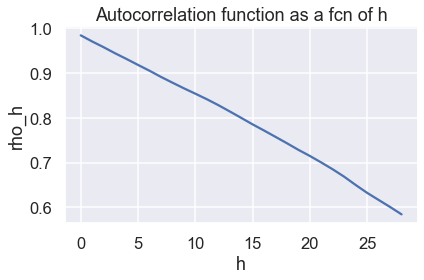

In [14]:
np.random.seed(123)
width = 0.1
samples, acc_ratio = sampler(posterior_function, no_of_samples=1000, start_position=.5, proposal_width=width, plot=False);
hmax = 30  # A hmax of 30 was seen to give a nice exponential autocorrelation time.
auto_corr_time = ac_time(samples, hmax)
print(f'Acceptance ratio for proposal width={width} is {acc_ratio} and autocorrelation time is {np.round(auto_corr_time,2)}')

Around 2 proposal width gives an acceptance ratio of 0.54. This is somewhat high, but not too high so that almost all of the proposed steps are accepted.